# Wstępna analiza IUM
Paweł Bęza <br>
Artur Mazur

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem biznesowy
<blockquote>
Chcemy przewidzieć czy dana sesja użytkownika zakończy się zakupem na podstawie danych sesji.
Skuteczna klasyfikacja sesji, które zakończą się zakupem umożliwi konsultantom szybsze rozwiązywanie problemów
</blockquote>

## Zadanie modelowania
Zadaniem jest klasyfikacja binarna odpowiadająca na pytanie "Czy sesja użytkownika zakończy się zakupem?".
Do dyspozycji mamy historyczne dane składające się z:
* bazy użytkowników
* katalogu produktów
* historia sesji
* dane dotyczące wysyłki zakupionych produktów

## Analiza zbioru danych
Najpierw zastanowilismy się, do których informacji mamy dostęp w trakcie trwania sesji.

Zauważyliśmy, że dane dotyczące wysyłki są dostępne dopiero po dokonaniu zakupu, dlatego z tej informacji nie będziemy mogli skorzystać.
Informacje zawarte w pozostałych tabelach są dostępne w trakcie trwania sesji, więc przeszliśmy do bardziej szczegółowej analizy tego fragmentu danych.

Postanowiliśmy wyróżnić ze zbioru danych następujące informacje:
* *user_id* - identyfikator użytkownika
* [*purchase*](#purchase) - wartość boolowska odpowiadająca na pytanie czy sesja zakończyła się zakupem na podstawie kolumny event_type
* [*weekend*](#weekend) - wartość boolowska odpowiadająca na pytanie czy sesja trwa w weekend na podstawie kolumny timestamp
* *duration* - długość trwania sesji w sekundach obliczana jako
$session\_event\_timestamp - session\_start\_timestamp$ gdzie: <br> *session_event_timestamp* - timestamp eventu z tabeli *sessions* <br> *session_event_timestamp* - timestamp eventu, który nastąpił najwcześniej podczas trwania sesji, do której należy dany rekord
* *offered_discound* - wysokość zniżki
* *month*, *day*, *hour* - miesiąc, dzień, godzina na podstawie kolumny timestamp
* *click_rate* - liczba zdarzeń(event'ów) do aktualnego rekordu na minutę
* *item_views* - liczba obejrzanych przedmiotów
* *unique_item_views* - liczba przejrzanych unikalnych przedmiotów
* *unique_categories* - liczba przejrzanych unikalnych kategorii

Zmodyfikowany zbiór danych zapisaliśmy w pliku *merged_dataset*

### Przykładowe rekordy zawierające powyższe informacje

In [45]:
sessions = pd.read_csv("merged_dataset", sep=' ')
sessions.head()

,Unnamed: 0,session_id,user_id,offered_discount,duration,weekend,month,day,hour,unique_item_views,item_views,click_rate,unique_categories,purchase
0,0,100001,102.0,20,0.0,False,January,26.0,14.0,1.0,1.0,0.000000,1.0,True
1,1,100001,102.0,20,88.0,False,January,26.0,14.0,2.0,2.0,1.363636,2.0,True
2,2,100001,102.0,20,180.0,False,January,26.0,14.0,3.0,3.0,1.000000,2.0,True
3,3,100001,102.0,20,185.0,False,January,26.0,14.0,4.0,4.0,1.297297,2.0,True
4,4,100001,102.0,20,471.0,False,January,26.0,14.0,5.0,5.0,0.636943,2.0,True


In [46]:
purchases = 0
without_pur = 0
current_id = 0
weekend = 0
week = 0
for i in range(sessions.shape[0]):
    if(sessions.iloc[i]['session_id'] != current_id):
        session = sessions.iloc[i]
        current_id = session['session_id']
        if(session['purchase']):
            purchases += 1
            if(session['weekend']):
                weekend += 1
            else:
                week += 1
        else:
            without_pur += 1

if(sessions.iloc[i]['purchase']):
    purchases += 1
    if(sessions.iloc[i]['weekend']):
        weekend += 1
    else:
        week += 1
else:
    without_pur += 1

In [47]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  
                    textcoords="offset points",
                    ha='center', va='bottom')

### Ile sesji zakończyło się zakupem? <a name="purchase"></a>
Liczba sesji w obu klasach jest porównywalna dlatego można powiedzieć, że mamy styczność z danymi zbalansowanymi.

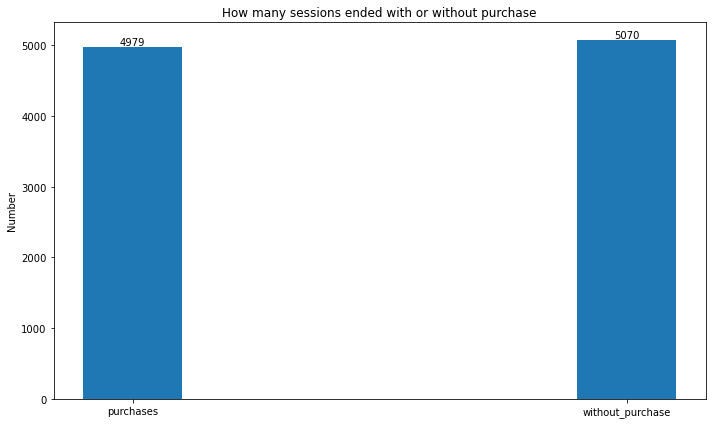

In [48]:
labels = ['purchases', 'without_purchase']
values = [purchases, without_pur]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10,6))
rects = ax.bar(x, values, width)

ax.set_ylabel('Number')
ax.set_title('How many sessions ended with or without purchase')
ax.set_xticks(x)
ax.set_xticklabels(labels)

autolabel(rects)

fig.tight_layout()

plt.show()

### Weekend <a name="weekend"></a>
Analizując to czy sesja trwa w weekend chceiliśmy zweryfikować czy w weekend jest więcej sesji ogólem oraz w szczególności tych kupujących.

### Zakupy w weekend vs w dzień roboczy  

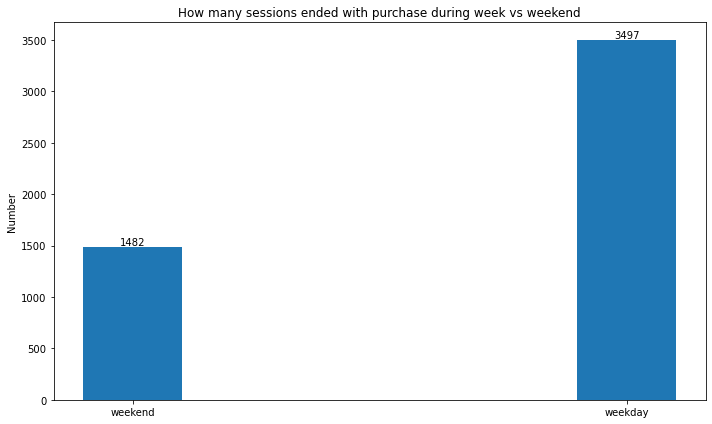

In [49]:
labels = ['weekend', 'weekday']
values = [weekend, week]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10,6))
rects = ax.bar(x, values, width)

ax.set_ylabel('Number')
ax.set_title('How many sessions ended with purchase during week vs weekend')
ax.set_xticks(x)
ax.set_xticklabels(labels)

autolabel(rects)

fig.tight_layout()

plt.show()

### Średnia dzienna liczba zakupów w weekend vs w dzień roboczy

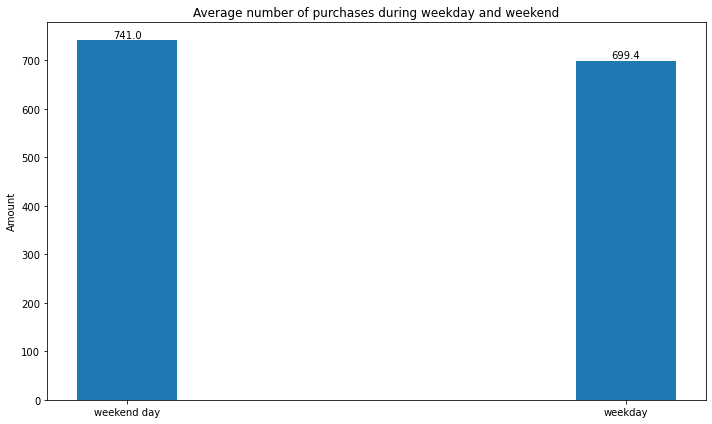

In [50]:
labels = ['weekend day', 'weekday']
values = [weekend/2, week/5]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10,6))
rects = ax.bar(x, values, width)

ax.set_ylabel('Amount')
ax.set_title('Average number of purchases during weekday and weekend')
ax.set_xticks(x)
ax.set_xticklabels(labels)

autolabel(rects)

fig.tight_layout()

plt.show()

In [51]:
purchases_discount = 0
purchases_without_d = 0
without_pur_discount = 0
without_pur_without_d = 0
current_id = 0
for i in range(sessions.shape[0]):
    if(sessions.iloc[i]['session_id'] != current_id):
        current_id = sessions.iloc[i]['session_id']
        if(sessions.iloc[i]['purchase']):
            if(sessions.iloc[i]['offered_discount']):
                purchases_discount += 1
            else:
                purchases_without_d += 1
        else:
            if(sessions.iloc[i]['offered_discount']):
                without_pur_discount += 1
            else:
                without_pur_without_d += 1
                
if(sessions.iloc[i]['purchase']):
    if(sessions.iloc[i]['offered_discount']):
        purchases_discount += 1
    else:
        purchases_without_d += 1
else:
    if(sessions.iloc[i]['offered_discount']):
        without_pur_discount += 1
    else:
        without_pur_without_d += 1

                

### Czy oferowana zniżka wpływała na dokonanie zakupu?

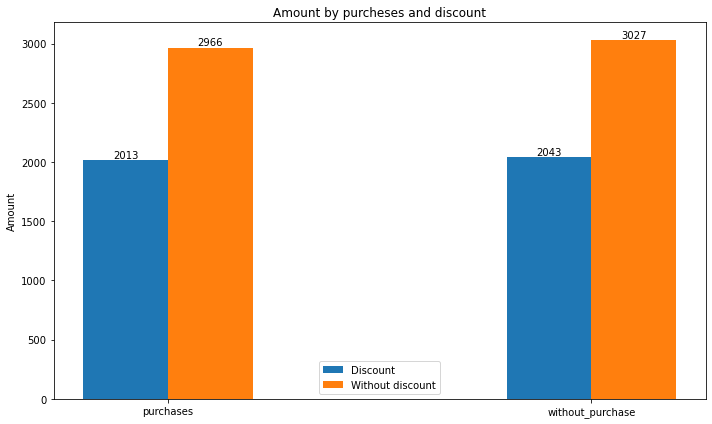

In [52]:
labels = ['purchases', 'without_purchase']
with_discount = [purchases_discount, without_pur_discount]
without_discount = [purchases_without_d, without_pur_without_d]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, with_discount, width, label='Discount')
rects2 = ax.bar(x + width/2, without_discount, width, label='Without discount')
                
ax.set_ylabel('Amount')
ax.set_title('Amount by purcheses and discount')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
                
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# Jak wpływała wielkość oferowanej zniżki?

In [53]:
discounts = sessions['offered_discount'].unique()
discounts.sort()
discounts

array([ 0,  5, 10, 15, 20])

In [54]:
data = [[0,0], [0,0], [0,0], [0,0], [0,0]]
current_id = 0
for i in range(sessions.shape[0]):
    if(sessions.iloc[i]['session_id'] != current_id):
        current_id = sessions.iloc[i]['session_id']
        if(sessions.iloc[i]['purchase']):
            discount_index = sessions.iloc[i]['offered_discount']/5
            data[int(discount_index)][0] += 1
        else:
            discount_index = sessions.iloc[i]['offered_discount']/5
            data[int(discount_index)][1] += 1
            
if(sessions.iloc[i]['purchase']):
    discount_index = sessions.iloc[i]['offered_discount']/5
    data[int(discount_index)][0] += 1
else:
    discount_index = sessions.iloc[i]['offered_discount']/5
    data[int(discount_index)][1] += 1


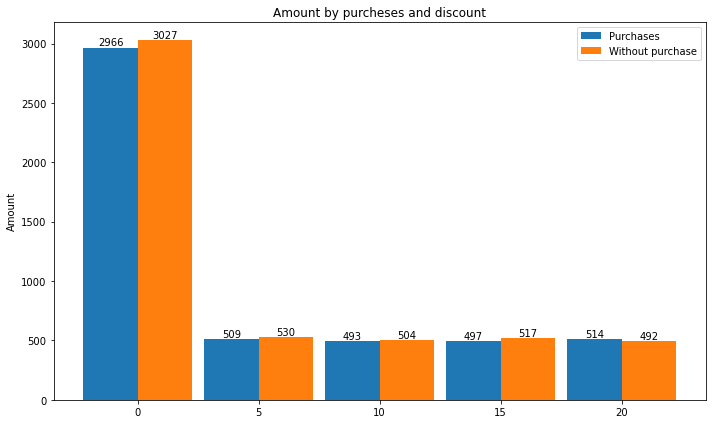

In [55]:
labels = ['0', '5', '10', '15', '20']
purchases = [data[0][0], data[1][0], data[2][0], data[3][0], data[4][0]]
without_purchases = [data[0][1], data[1][1], data[2][1], data[3][1], data[4][1]]

x = np.arange(len(labels))
width = 0.45

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, purchases, width, label='Purchases')
rects2 = ax.bar(x + width/2, without_purchases, width, label='Without purchase')
                
ax.set_ylabel('Amount')
ax.set_title('Amount by purcheses and discount')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
                
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# Długość sesji a zakup

In [56]:
current_id = 100001
session_hour_pur = np.zeros(24)
session_hour_without = np.zeros(24)
current_duration = 0
purchase = False
data_set = []
for i in range(sessions.shape[0]):
    if(sessions.iloc[i]['session_id'] != current_id):
        temp = [current_id, current_duration, purchase]
        data_set.append(temp)
        current_id = sessions.iloc[i]['session_id']
        current_duration = sessions.iloc[i]['duration']
        purchase = sessions.iloc[i]['purchase']
        if(purchase):
            session_hour_pur[int(sessions.iloc[i]['hour'])] += 1
        else:
            session_hour_without[int(sessions.iloc[i]['hour'])] += 1
    else:
        current_duration = sessions.iloc[i]['duration']
        
temp = [current_id, current_duration, purchase]
data_set.append(temp)
purchase = sessions.iloc[i]['purchase']
if(purchase):
    session_hour_pur[int(sessions.iloc[i]['hour'])] += 1
else:
    session_hour_without[int(sessions.iloc[i]['hour'])] += 1

In [57]:
purchases = []
without_p = []

for i in range(len(data_set)):
    if(data_set[i][2]):
        purchases.append(data_set[i][1])
    else:
        without_p.append(data_set[i][1])

pur_time = np.array(purchases)
without_pur_time = np.array(without_p)

In [58]:
df = pd.DataFrame({"Average" : [np.average(pur_time), np.average(without_pur_time)],
                   "Median" : [np.median(pur_time), np.median(without_pur_time)],
                   "Min" : [np.min(pur_time), np.min(without_pur_time)],
                   "Max" : [np.max(pur_time), np.max(without_pur_time)],
                   "Variance" : [np.var(pur_time), np.var(without_pur_time)],
                   "Standard deviation" : [np.std(pur_time), np.std(without_pur_time)],
                   "Amount" : [len(pur_time), len(without_pur_time)]})
df = df.rename(index={0 : "Purchases", 1 : "Without Purchase"})
df

,Average,Median,Min,Max,Variance,Standard deviation,Amount
Purchases,469.188429,292.0,5.0,2158.0,177233.239705,420.990783,4978
Without Purchase,327.468836,141.0,0.0,2368.0,183099.826938,427.901656,5070


# Długość trwania sesji zakończonej zakupem

In [59]:
purchase = np.zeros(22)
for i in range(len(pur_time)):
    purchase[int(pur_time[i]/100)] += 1

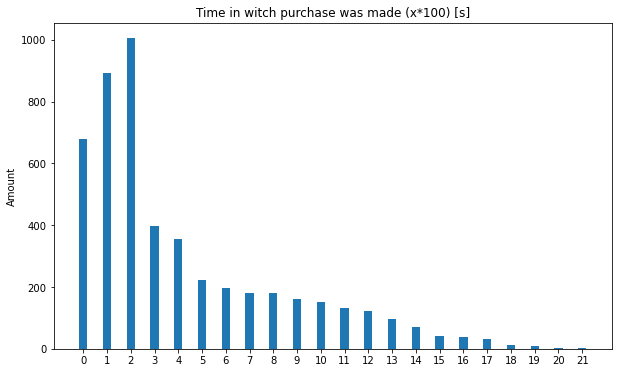

In [60]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
          '14', '15', '16', '17', '18', '19', '20', '21']

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects = ax.bar(x, purchase, width)

ax.set_ylabel('Amount')
ax.set_title('Time in witch purchase was made (x*100) [s]')
ax.set_xticks(x)
ax.set_xticklabels(labels)


plt.show()

# Długość trwania sesji która nie zakończyła się zakupem

In [61]:
without = np.zeros(24)
for i in range(len(without_pur_time)):
    without[int(without_pur_time[i]/100)] += 1

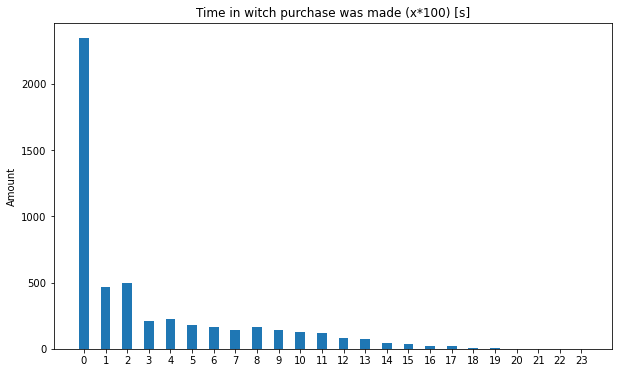

In [62]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
          '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']

x = np.arange(len(labels))
width = 0.45

fig, ax = plt.subplots(figsize=(10,6))
rects = ax.bar(x, without, width)

ax.set_ylabel('Amount')
ax.set_title('Time in witch purchase was made (x*100) [s]')
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.show()

# Godzina rozpoczęcia sesji a dokanie zakupu

In [63]:
hours = sessions['hour'].unique()
hours.sort()
hours

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

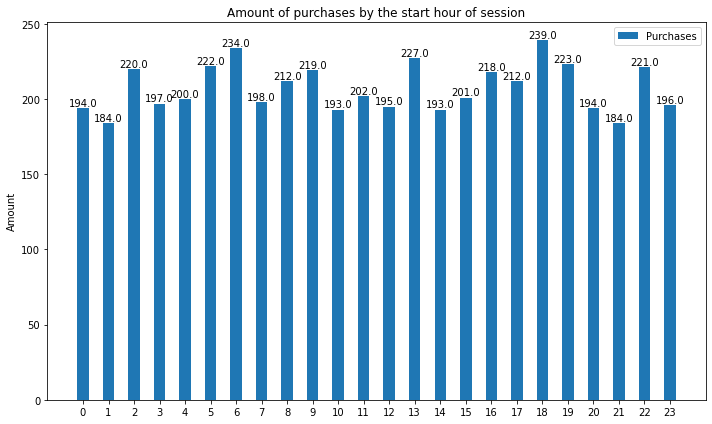

In [64]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
          '15', '16', '17', '18', '19', '20', '21', '22', '23']

x = np.arange(len(labels))
width = 0.45

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x, session_hour_pur, width, label='Purchases')

ax.set_ylabel('Amount')
ax.set_title('Amount of purchases by the start hour of session')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)

fig.tight_layout()

plt.show()

# Godzina rozpoczęcia sesji a brak zakupu

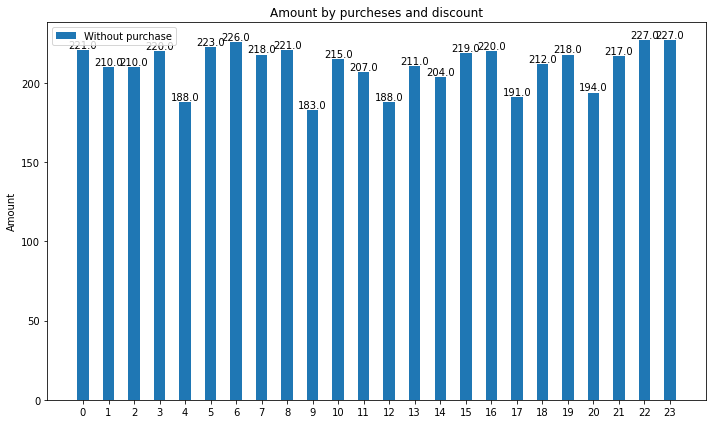

In [65]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
          '15', '16', '17', '18', '19', '20', '21', '22', '23']

x = np.arange(len(labels))
width = 0.45

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x, session_hour_without, width, label='Without purchase')

ax.set_ylabel('Amount')
ax.set_title('Amount by purcheses and discount')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)

fig.tight_layout()

plt.show()    

# Różnica między ilością sesji zakończonych zakupem a tych bez zakupu w zalezności od godziny rozpoczęcia sesji

In [66]:
difference = []
for i in range(len(session_hour_pur)):
    difference.append(session_hour_pur[i] - session_hour_without[i])

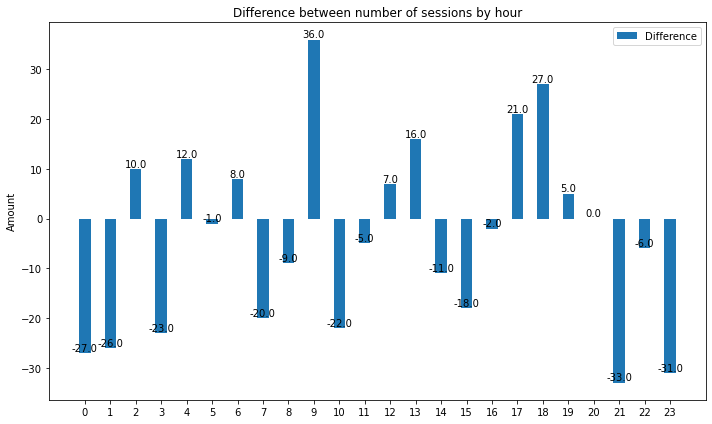

In [67]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
          '15', '16', '17', '18', '19', '20', '21', '22', '23']

x = np.arange(len(labels))
width = 0.45

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x, difference, width, label='Difference')

ax.set_ylabel('Amount')
ax.set_title('Difference between number of sessions by hour')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)

fig.tight_layout()

plt.show()    

# Ilość przeglądanych produktów a dokonanie zakupu

In [68]:
max_items = 0
max_categories = 0
current_session = 100001 
items_shown = []
items_shown_w = []
categories_shown = []
categories_shown_w = []

for i in range(sessions.shape[0]):
    if(sessions.iloc[i]['session_id'] != current_session):
        if(sessions.iloc[i]['purchase']):
            items_shown.append(max_items)
            categories_shown.append(max_categories)
        else:
            items_shown_w.append(max_items)
            categories_shown_w.append(max_categories)
        current_session = sessions.iloc[i]['session_id']
    max_items = sessions.iloc[i]['unique_item_views']
    max_categories = sessions.iloc[i]['unique_categories']
    
if(sessions.iloc[i]['purchase']):
    items_shown.append(max_items)
    categories_shown.append(max_categories)
else:
    items_shown_w.append(max_items)
    categories_shown_w.append(max_categories)

In [69]:
unique, counts = np.unique(np.array(items_shown), return_counts = True)
unique_w, counts_w = np.unique(np.array(items_shown_w), return_counts = True)

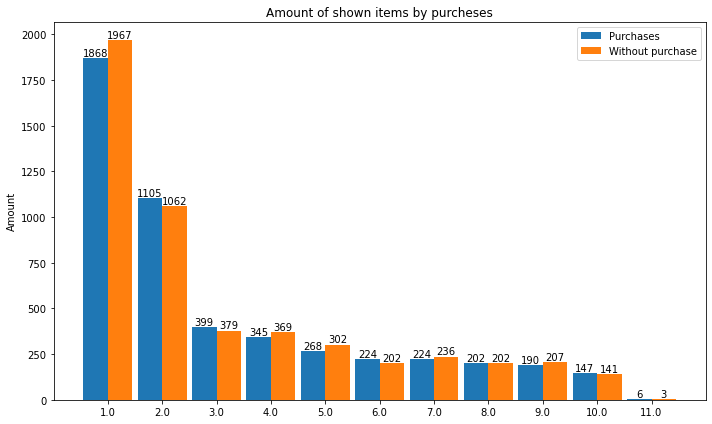

In [70]:
x = np.arange(len(unique))
width = 0.45

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, counts, width, label='Purchases')
rects2 = ax.bar(x + width/2, counts_w, width, label='Without purchase')
                
ax.set_ylabel('Amount')
ax.set_title('Amount of shown items by purcheses')
ax.set_xticks(x)
ax.set_xticklabels(unique)
ax.legend()
                
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# Ilość przeglądanych kategorii a zakup

In [71]:
unique, counts = np.unique(np.array(categories_shown), return_counts = True)
unique_w, counts_w = np.unique(np.array(categories_shown_w), return_counts = True)

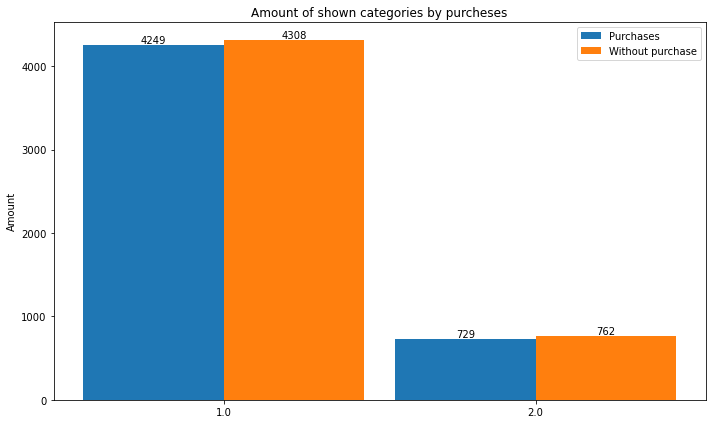

In [72]:
x = np.arange(len(unique))
width = 0.45

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, counts, width, label='Purchases')
rects2 = ax.bar(x + width/2, counts_w, width, label='Without purchase')
                
ax.set_ylabel('Amount')
ax.set_title('Amount of shown categories by purcheses')
ax.set_xticks(x)
ax.set_xticklabels(unique)
ax.legend()
                
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# Click rate a zakup

In [73]:
click_rate = 0
current_session = 100001 
click_rate_p = []
click_rate_w = []

for i in range(sessions.shape[0]):
    if(sessions.iloc[i]['session_id'] != current_session):
        if(sessions.iloc[i]['purchase']):
            click_rate_p.append(click_rate)
        else:
            click_rate_w.append(click_rate)
        current_session = sessions.iloc[i]['session_id']
    click_rate = sessions.iloc[i]['click_rate']

if(sessions.iloc[i]['purchase']):
    click_rate_p.append(click_rate)
else:
    click_rate_w.append(click_rate)

In [74]:
df = pd.DataFrame({"Average" : [np.average(click_rate_p), np.average(click_rate_w)],
                   "Median" : [np.median(click_rate_p), np.median(click_rate_w)],
                   "Min" : [np.min(click_rate_p), np.min(click_rate_w)],
                   "Max" : [np.max(click_rate_p), np.max(click_rate_w)],
                   "Variance" : [np.var(click_rate_p), np.var(click_rate_w)],
                   "Standard deviation" : [np.std(click_rate_p), np.std(click_rate_w)],
                   "Amount" : [len(click_rate_p), len(click_rate_w)]})
df = df.rename(index={0 : "Purchases", 1 : "Without Purchase"})
df

,Average,Median,Min,Max,Variance,Standard deviation,Amount
Purchases,0.817685,0.490402,0.0,24.0,3.093602,1.758864,4978
Without Purchase,0.811828,0.483871,0.0,24.0,3.083380,1.755955,5070


## Literatura
* [Towards early purchase intention prediction in online session based retailing systems]("https://link.springer.com/article/10.1007/s12525-020-00448-x")